Michał Szczurek grupa wtorek 12.50 B

# 1. Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# 2. Biblioteki wykorzystane w programie

In [3]:
import math
import random
import numpy
import random 
random.seed(1234) # wybranie ziarna

# 3. Generowanie zestawów danych

3.1 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

In [4]:
tab1 = [(random.uniform(-1000, 1000),random.uniform(-1000, 1000)) for i in range(10**5)]

3.2 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14]

In [5]:
tab2 =  [(random.uniform(-10**14, 10**14),random.uniform(-10**14, 10**14)) for i in range(10**5)]

3.3 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

In [6]:
R = 100
tab3 =[None for i in range(1000)]
for i in range(1000):
    theta = random.uniform(0, 2*math.pi)
    x = R * math.cos(theta)
    y = R * math.sin(theta)
    tab3[i] = (x,y)

3.4 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b)

In [7]:
a = [-1.0, 0.0]
b = [1.0, 0.1]

# Prostą wyznaczono, przy pomocy dwóch równań:
# 1) y1 = m * x1 + l
# 2) y2 = m * x2 + l

m = (a[1]-b[1])/(a[0]-b[0])
l = a[1] - m*a[0]

border_x1 = (1000-l)/m 
border_x2 = (-1000-l)/m
min_x = min(border_x1, border_x2)
max_x = max(border_x1, border_x2)
min_x = max(-1000,min_x) # żeby y <= 1000
max_x = min(1000, max_x) # żeby y >= -1000

tab4 = [None for i in range(1000)]
for i in range (1000):
    x = random.uniform(min_x, max_x)
    y = m*x + l
    tab4[i] = (x, m*x + l)

3.5 Wizualizacji zestawów danych

<IPython.core.display.Javascript object>


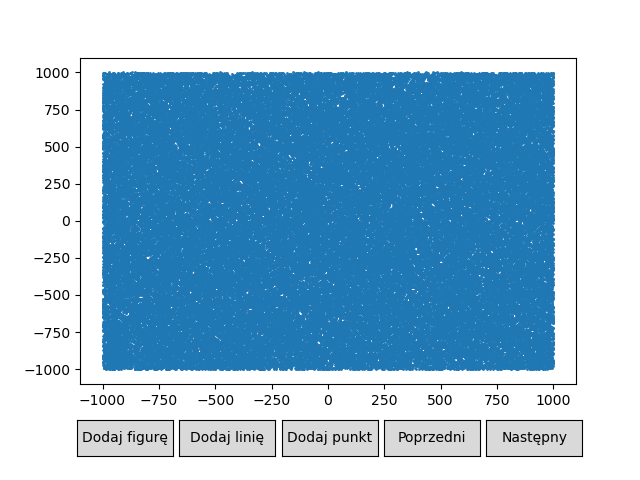

In [8]:
%matplotlib notebook
scenes = [Scene([PointsCollection(tab1, s = 1)]),
           Scene([PointsCollection(tab2, s = 1)]),
           Scene([PointsCollection(tab3, s = 1)]),
           Scene([PointsCollection(tab4, s = 1)])]
plot = Plot(scenes)    
plot.draw()

# 4. Funkcje obliczające wyznacznik

4.1 Zaimplementowane samodzielnie

In [1]:
def det3x3 (a,b,c):
    return a[0]*b[1] + b[0]*c[1] + c[0]*a[1] - c[0]*b[1] - a[0]*c[1] - b[0]*a[1]

det3x3((0.03,0.025),(0.01,-0.01),(0.018,0.001))

5.9999999999999995e-05

In [10]:
def det2x2 (a,b,c):
    return (a[0]-c[0])*(b[1]-c[1])-(b[0]-c[0])*(a[1]-c[1])

4.2 Dostarczone przez bibliotekę numpy

In [11]:
def numpy_det3x3(a,b,c):
    return numpy.linalg.det(numpy.array([[a[0],a[1],1],[b[0],b[1],1],[c[0],c[1],1]]))

In [12]:
def numpy_det2x2(a,b,c):
    return numpy.linalg.det(numpy.array([[a[0]-c[0],a[1]-c[1]],[b[0]-c[0],b[1]-c[1]]]))

# 5. Funckja klasyfikująca punkty

In [183]:
def classify(points, det, epsillon, a, b):   
    (left, collinear, right) = ([], [], [])
    for point in points:
        if -epsilon <= det(a, b, point) <= epsilon:
            collinear.append(point)
    
        elif det (a, b, point) < -epsilon:
            right.append(point)
        else:
            left.append(point)    
    collection = [PointsCollection(left, color = 'blue',s = 1),
                  PointsCollection(right, color = 'green',s = 1),
                  PointsCollection(collinear, color = 'orange',s = 1)]
  
    Plot(points = collection,).draw()
    print("Left", len(left))
    print("collinear", len(collinear))
    print("Right", len(right))

# 6. Klasyfikacja punktów

6.1 Klasyfikacja punktów ze wszystkich zestawów przy zmiennej tolerancji. Tutaj przykładowo dla 10^(-14)

In [ ]:
epsilon = 10**(14)

 kolor zielony- punkt z prawej strony (a,b)

   kolor niebieski- punkt z lewej strony (a,b)


kolor pomarańczowy- punkt współlinowy z (a,b)

6.1.1 Zestaw 1

<IPython.core.display.Javascript object>


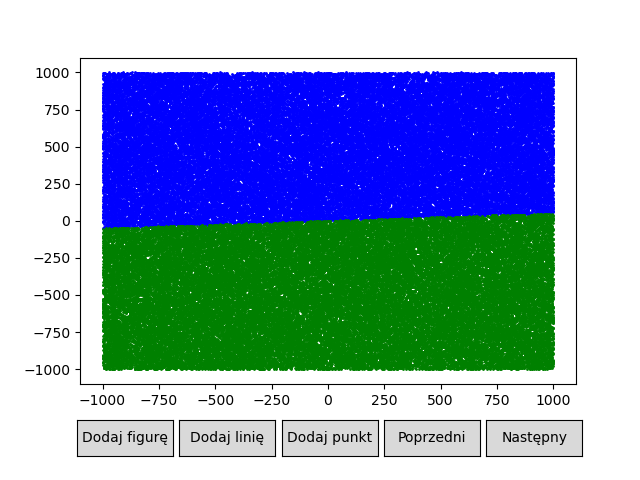

Left 50167
collinear 0
Right 49833


In [331]:
classify(tab1, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


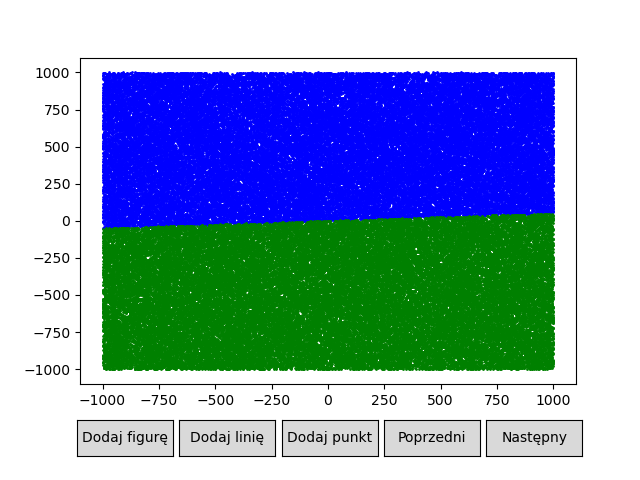

Left 50167
collinear 0
Right 49833


In [332]:
classify(tab1, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


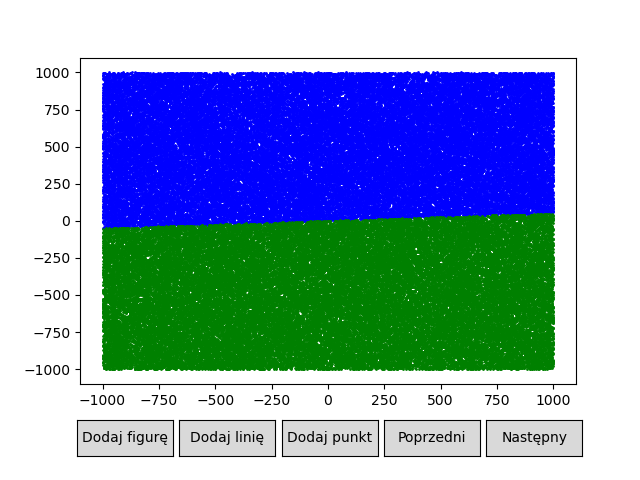

Left 50167
collinear 0
Right 49833


In [333]:
classify(tab1, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


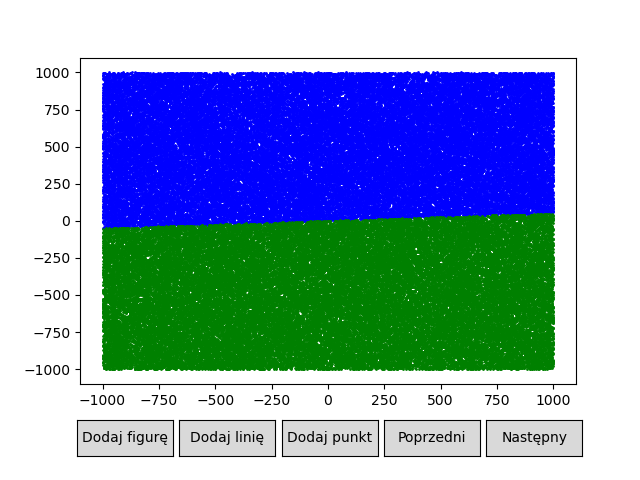

Left 50167
collinear 0
Right 49833


In [334]:
classify(tab1, numpy_det2x2, epsilon, a, b)

6.1.2 Zestaw 2

<IPython.core.display.Javascript object>


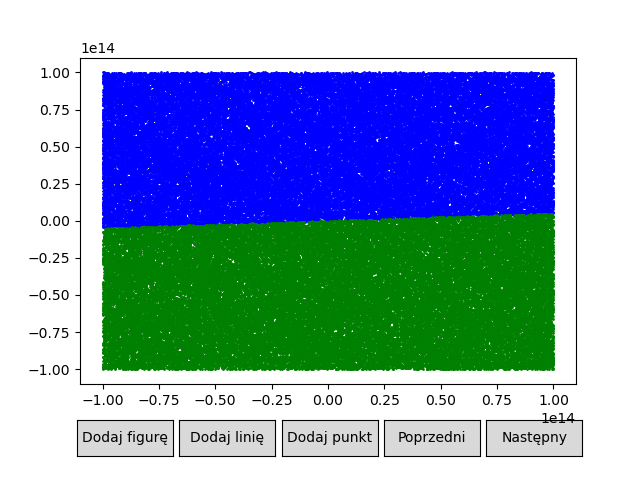

Left 50031
collinear 0
Right 49969


In [335]:
classify(tab2, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


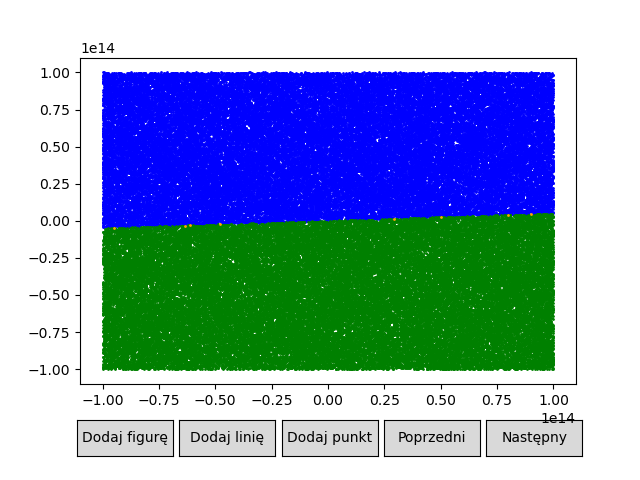

Left 50028
collinear 8
Right 49964


In [336]:
classify(tab2, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


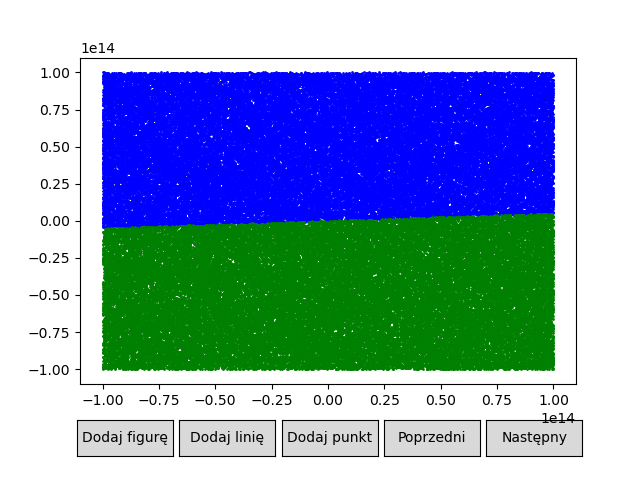

Left 50031
collinear 0
Right 49969


In [337]:
classify(tab2, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


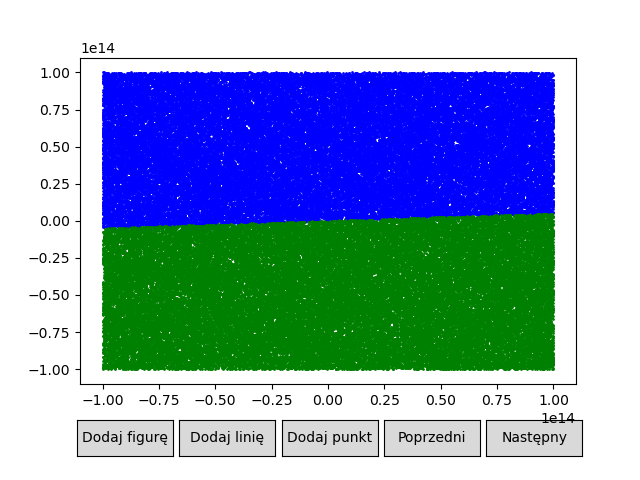

Left 50031
collinear 0
Right 49969


In [338]:
classify(tab2, numpy_det2x2, epsilon, a, b)

6.1.3 Zestaw 3

<IPython.core.display.Javascript object>


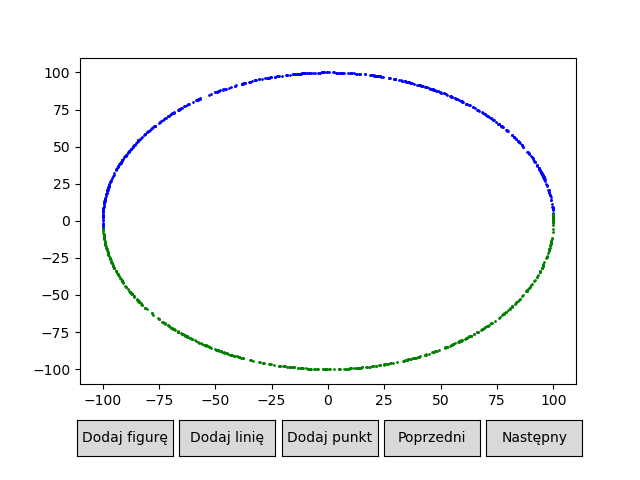

Left 518
collinear 0
Right 482


In [339]:
classify(tab3, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


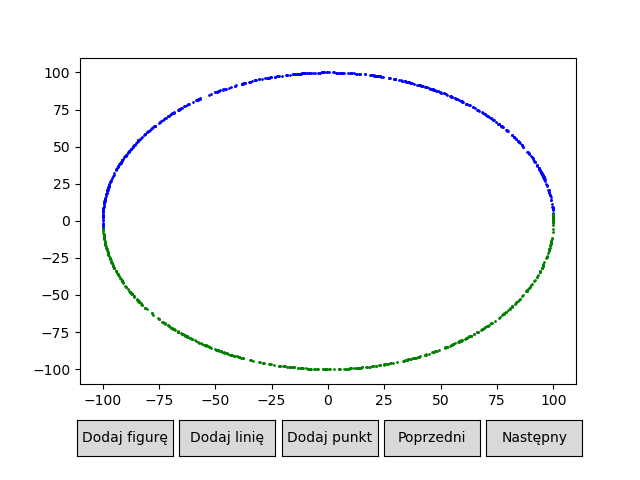

Left 518
collinear 0
Right 482


In [340]:
classify(tab3, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


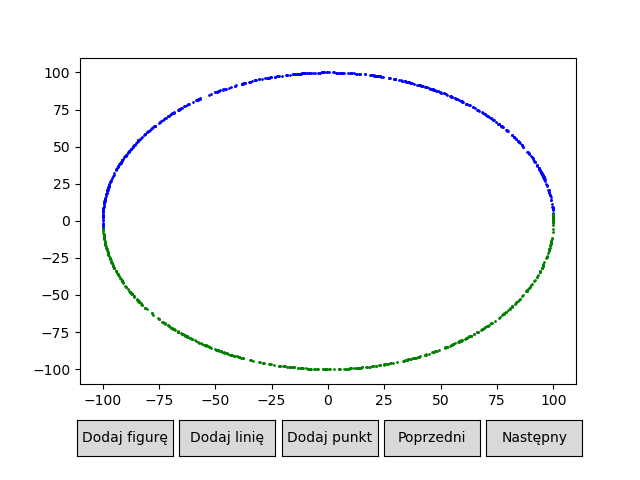

Left 518
collinear 0
Right 482


In [341]:
classify(tab3, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


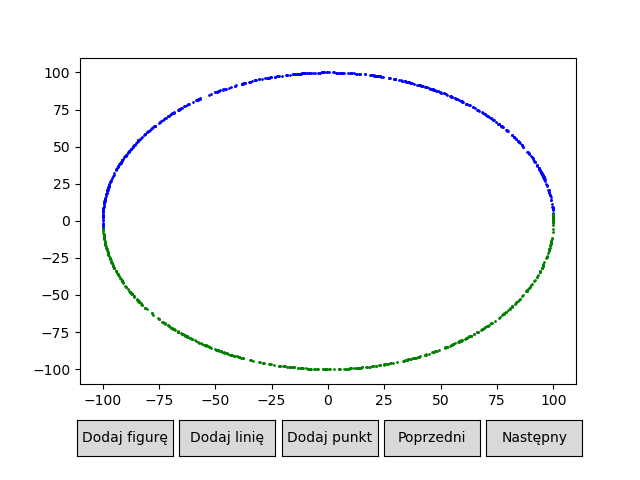

Left 518
collinear 0
Right 482


In [342]:
classify(tab3, numpy_det2x2, epsilon, a, b)

6.1.4 Zestaw 4

<IPython.core.display.Javascript object>


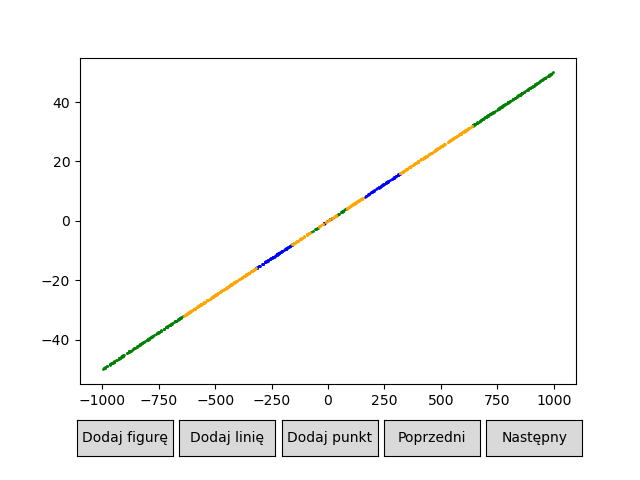

Left 171
collinear 460
Right 369


In [343]:
classify(tab4, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


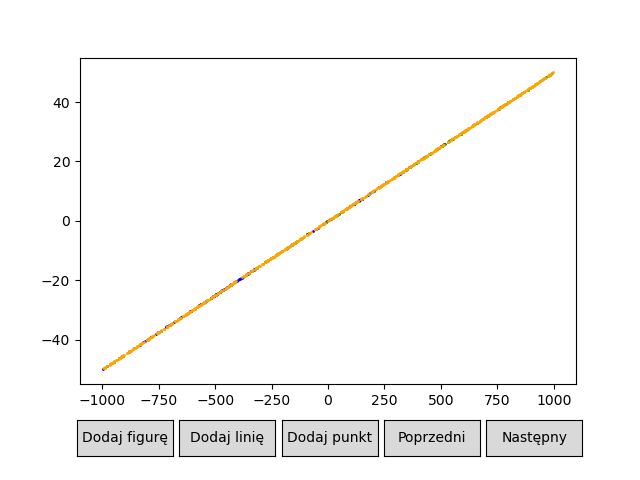

Left 142
collinear 733
Right 125


In [344]:
classify(tab4, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


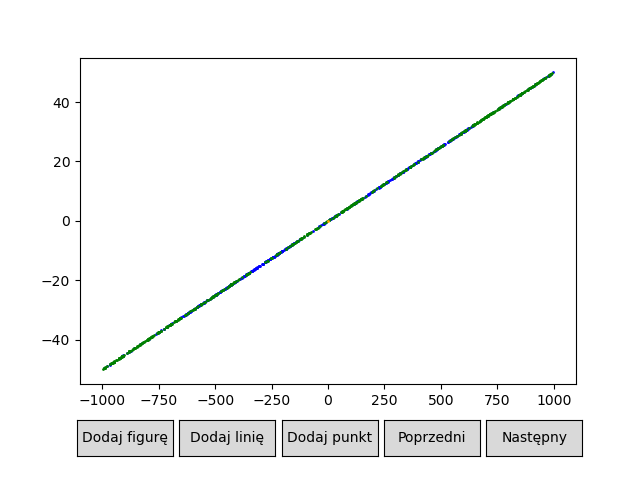

Left 483
collinear 1
Right 516


In [345]:
classify(tab4, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


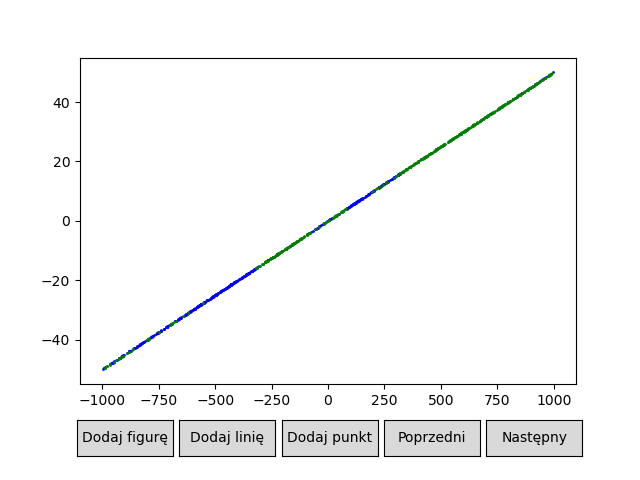

Left 492
collinear 0
Right 508


In [346]:
classify(tab4, numpy_det2x2, epsilon, a, b)

6.2 Dokładniejsza analiza zestawu 4

6.2.1 Klasyfikacja dla tolerancji błędu epsilon = 0

In [347]:
epsilon = 0

<IPython.core.display.Javascript object>


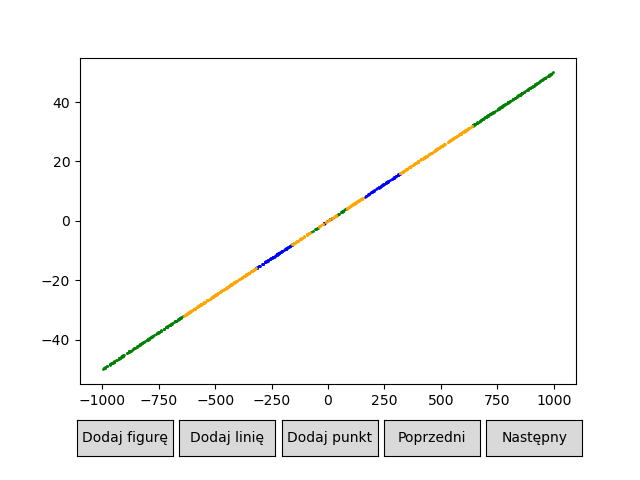

Left 171
collinear 460
Right 369


In [348]:
classify(tab4, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


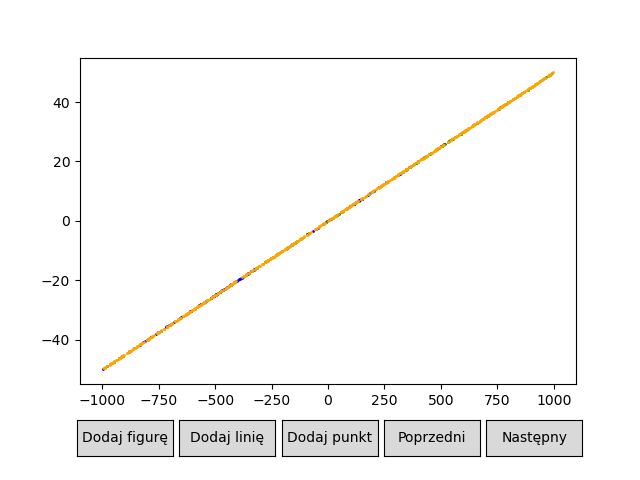

Left 142
collinear 733
Right 125


In [349]:
classify(tab4, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


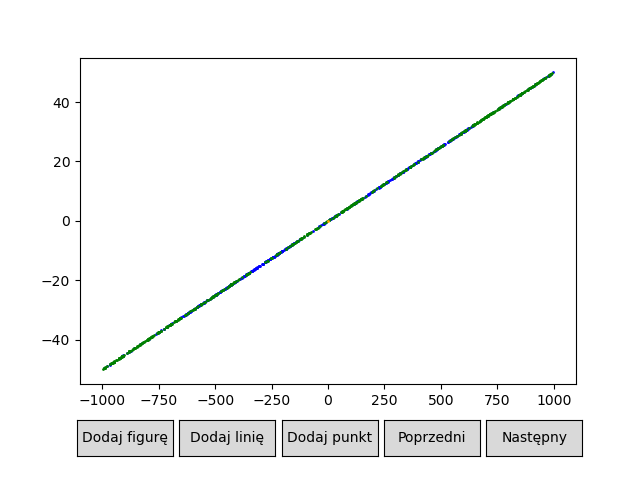

Left 483
collinear 1
Right 516


In [350]:
classify(tab4, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


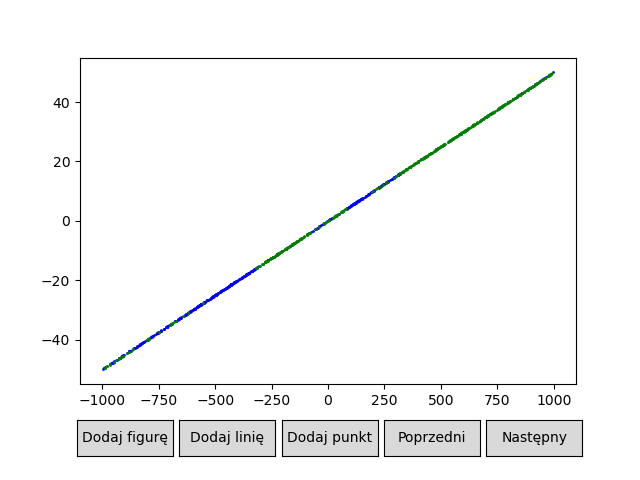

Left 492
collinear 0
Right 508


In [351]:
classify(tab4, numpy_det2x2, epsilon, a, b)

6.2.2 Klasyfikacja dla błedu epsilon = 10^(-12)

In [353]:
epsilon = 10**(-12)

<IPython.core.display.Javascript object>


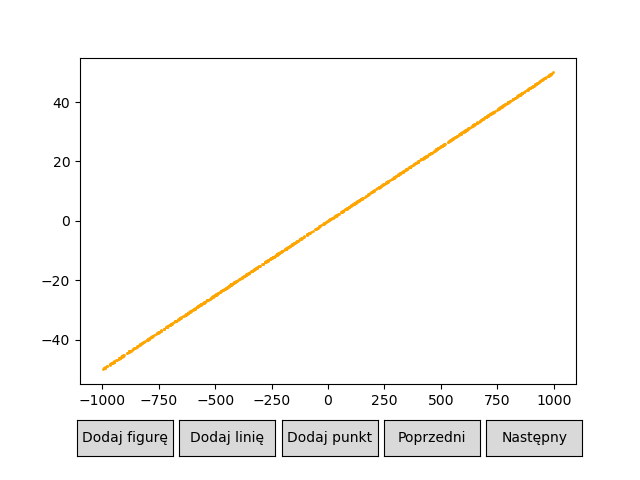

Left 0
collinear 1000
Right 0


In [354]:
classify(tab4, det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


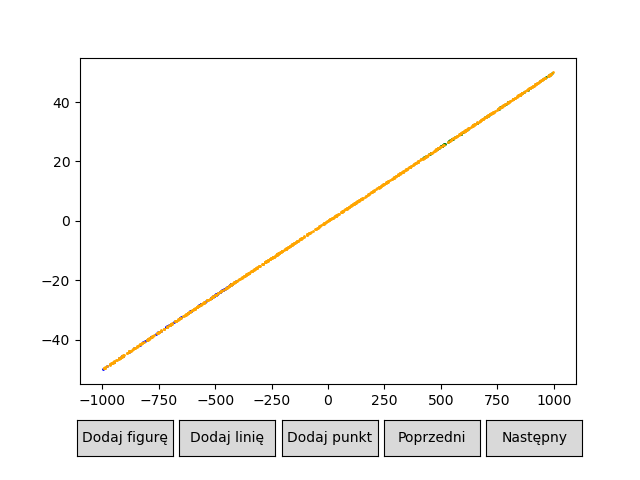

Left 82
collinear 854
Right 64


In [355]:
classify(tab4, det2x2, epsilon, a, b)

<IPython.core.display.Javascript object>


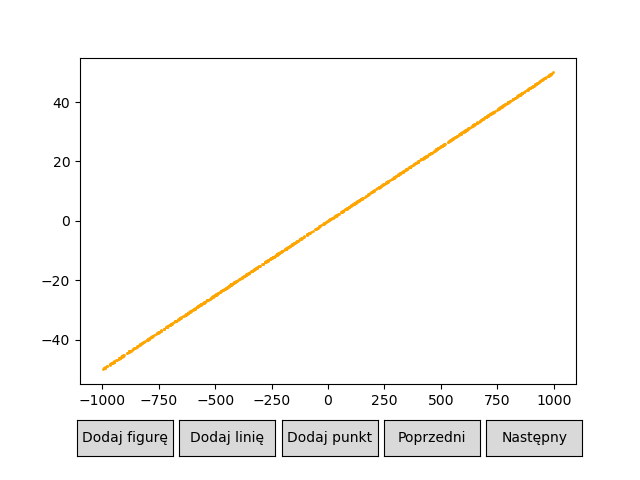

Left 0
collinear 1000
Right 0


In [356]:
classify(tab4, numpy_det3x3, epsilon, a, b)

<IPython.core.display.Javascript object>


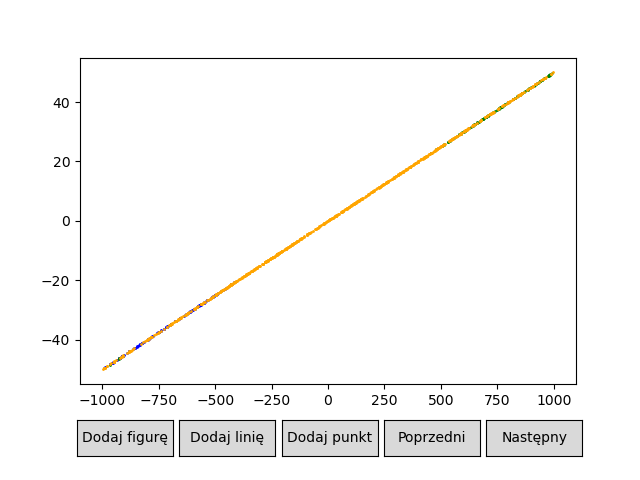

Left 136
collinear 734
Right 130


In [357]:
classify(tab4, numpy_det2x2, epsilon, a, b)

6.3 zestawienie różnic w klasyfikacji dla zestawu 4.

6.3.1 Funkcja zliczająca różnice

In [359]:
def differences(points, deta, detb, epsilon, a, b):
    diff = []
    for point in points:
        res = [None, None]
        if -epsilon <= deta(a, b, point) <= epsilon:
            res[0] = 'c'
        elif deta (a, b, point) < -epsilon:
            res[0] = 'r'
        else:
            res[0] = 'l'
            
        if -epsilon <= detb(a, b, point) <= epsilon:
            res[1] = 'c'
        elif detb (a, b, point) < -epsilon:
            res[1] = 'r'
        else:
            res[1] = 'l'
        
        if res[0] != res[1]:
            diff.append(point)
        
    collection = [PointsCollection(diff,s = 1)]
    Plot(points = collection,).draw()
    print("differences: ",len(diff))
        

6.3.1 Różnice dla epsilon = 10^(-12)

In [144]:
epsilon = 10**(-12)

dla det3x3 i det2x2:

<IPython.core.display.Javascript object>


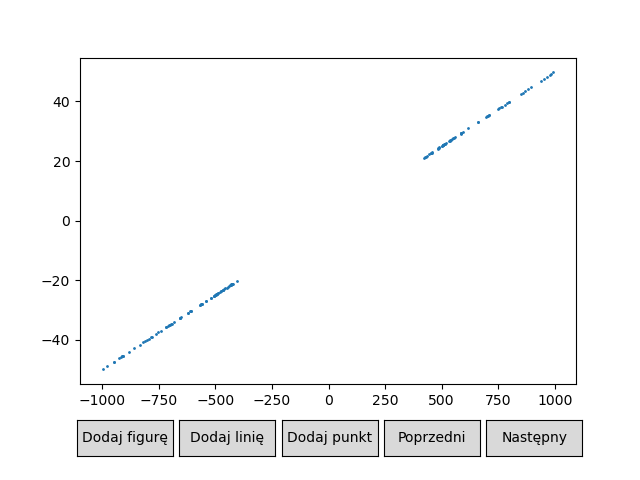

differences:  146


In [145]:
differences(tab4,det3x3,det2x2,epsilon,a,b)

dla numpy_det3x3 i numpy_det2x2:

<IPython.core.display.Javascript object>


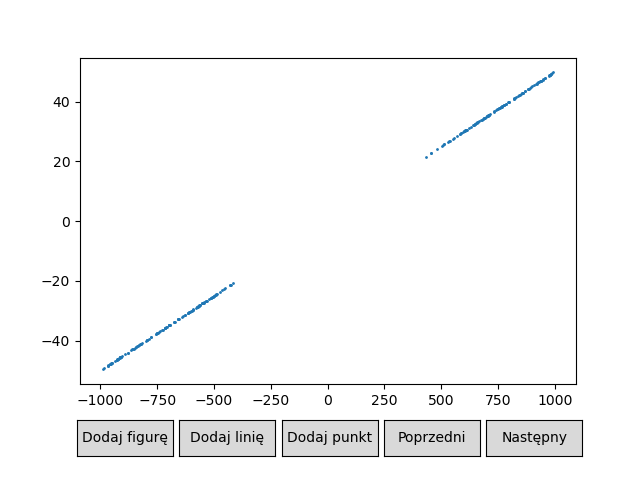

differences:  266


In [146]:
differences(tab4,numpy_det3x3,numpy_det2x2,epsilon,a,b)

dla numpy_det3x3 i det3x3:

<IPython.core.display.Javascript object>


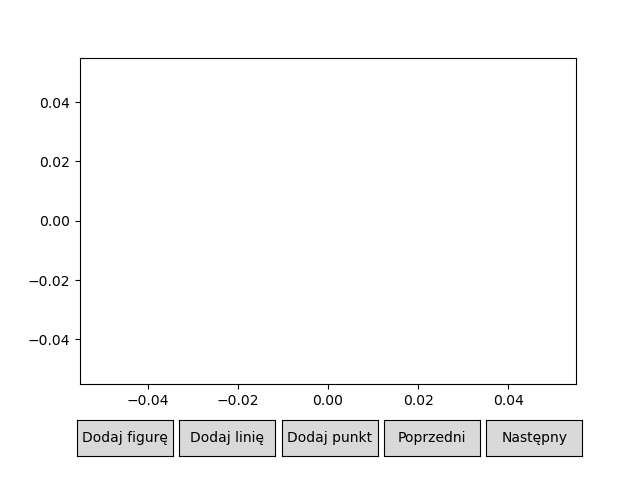

differences:  0


In [147]:
differences(tab4,numpy_det3x3,det3x3,epsilon,a,b)

dla numpy_det2x2 i det2x2:

<IPython.core.display.Javascript object>


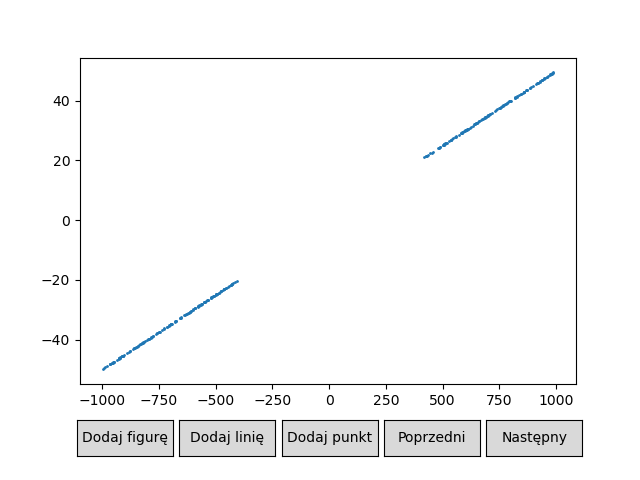

differences:  303


In [148]:
differences(tab4,numpy_det2x2,det2x2,epsilon,a,b)

dla numpy_det2x2 i det3x3:

<IPython.core.display.Javascript object>


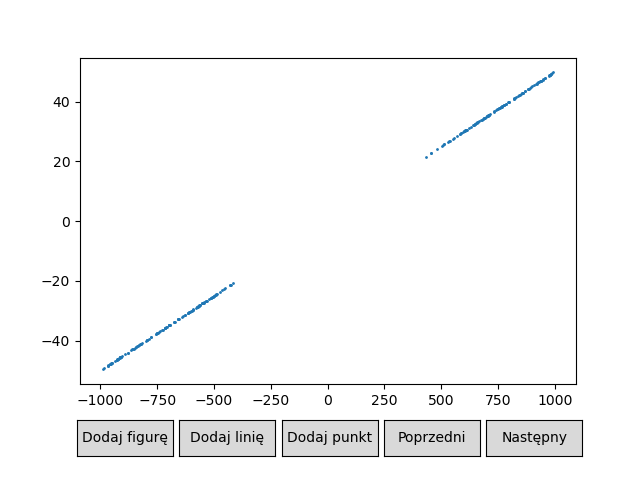

differences:  266


In [149]:
differences(tab4,numpy_det2x2,det3x3,epsilon,a,b)

dla numpy_det3x3 i det2x2:

<IPython.core.display.Javascript object>


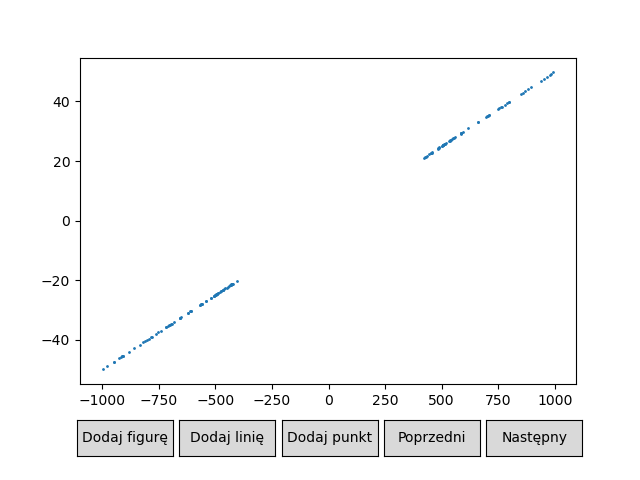

differences:  146


In [49]:
differences(tab4,numpy_det3x3,det2x2,epsilon,a,b)

# 7. testy na zmiennych o innej precyzji

In [270]:
tab4_32 = [numpy.float32(tab4[i]) for i in range(len(tab4))]

In [326]:
epsilon = 0 # przykładowa wartość

<IPython.core.display.Javascript object>


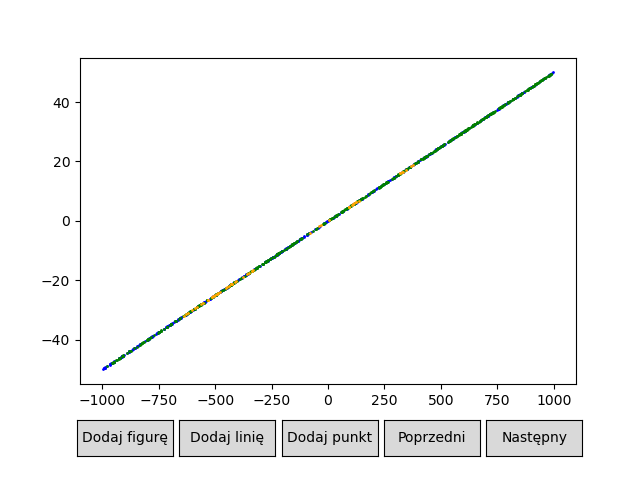

Left 456
collinear 55
Right 489


In [327]:
classify(tab4_32, det3x3, epsilon, a,b)

<IPython.core.display.Javascript object>


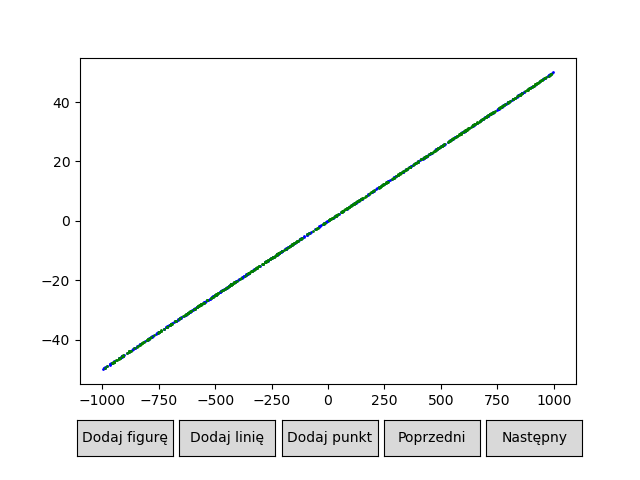

Left 498
collinear 0
Right 502


In [328]:
classify(tab4_32, numpy_det3x3, epsilon, a,b)

<IPython.core.display.Javascript object>


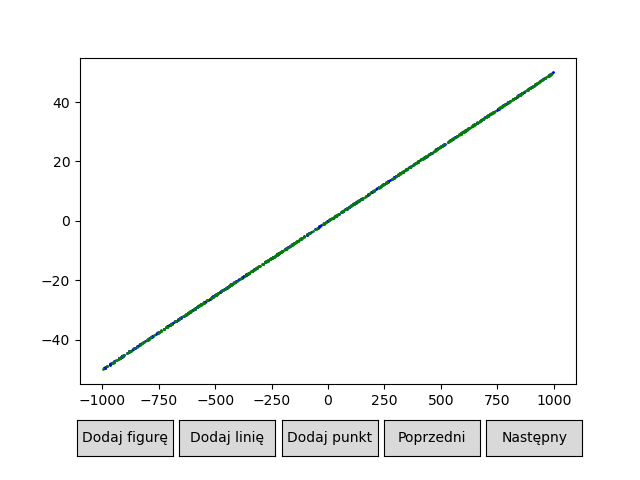

Left 491
collinear 0
Right 509


In [329]:
classify(tab4_32, numpy_det2x2, epsilon, a,b)

<IPython.core.display.Javascript object>


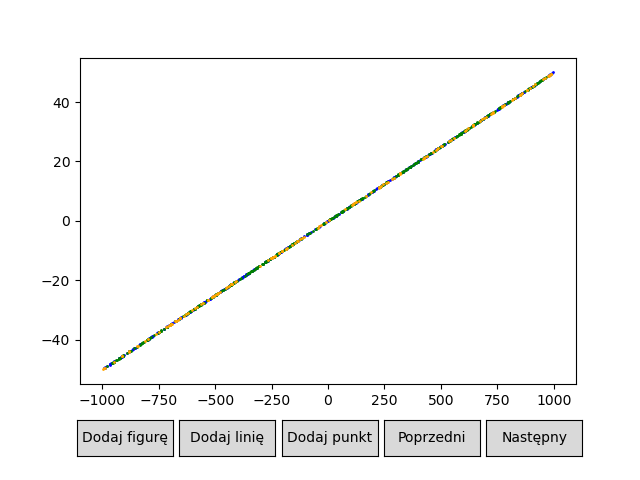

Left 410
collinear 162
Right 428


In [330]:
classify(tab4_32, det2x2, epsilon, a,b)